## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [80]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [81]:
# Выводим информацию о данных.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
None


### Вывод:
*Столбец date имеет тип данных - object.*

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [82]:
# Приводим столбец date к типу данных datetime.
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Группируем данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп.
duration = data.groupby(['group'])['date'].agg(['min','max']).reset_index()

# Проверка длительности тестирования.
if duration['min'].iloc[0] == duration['min'].iloc[1]\
and duration['max'].iloc[0] == duration['max'].iloc[1]:
    print(f"Тестирование началось {duration['min'].dt.date.iloc[0]}\
 и закончилось {duration['max'].dt.date.iloc[0]}.")
else:
    print('Длительность проведения тестирования между группами не совпадает.')

Тестирование началось 2021-01-02 и закончилось 2021-01-24.


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [83]:
# Группируем данные по группам и выводим информацию о количестве посещений сайта.
number_of_visits = data.groupby(['group'])['user_id'].count().reset_index()

# Выводим информацию.
print(f"Количество посешений сайта в группе А: {number_of_visits['user_id'].iloc[0]}.")
print(f"Количество посешений сайта в группе B: {number_of_visits['user_id'].iloc[1]}.")


# Группируем данные по группам и выводим информацию о количествах покупок.
number_of_purchase = data.groupby(['group'])['purchase'].sum().reset_index()

# Выводим информацию.
print(f"Количество покупок в группе А: {number_of_purchase['purchase'].iloc[0]}.")
print(f"Количество покупок в группе B: {number_of_purchase['purchase'].iloc[1]}.")


# Группируем данные по группам и выводим информацию о сумме покупок.
number_of_purchase = data.groupby(['group'])['price'].sum().reset_index()

# Выводим информацию.
print(f"Сумма покупок в группе А: {number_of_purchase['price'].iloc[0]/1000000} млн.руб.")
print(f"Сумма покупок в группе B: {number_of_purchase['price'].iloc[1]/1000000} млн.руб.")

Количество посешений сайта в группе А: 147202.
Количество посешений сайта в группе B: 147276.
Количество покупок в группе А: 17723.
Количество покупок в группе B: 17514.
Сумма покупок в группе А: 1436.26 млн.руб.
Сумма покупок в группе B: 1554.1 млн.руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [84]:
# Создаем множество пользователей группы А и группы B.
user_a = set(data[data['group'] == 'A']['user_id'])
user_b = set(data[data['group'] == 'B']['user_id'])

# Проверяем, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы.
user_intersection = user_a.intersection(user_b)

# Выводим информацию.
print(f"Количество уникальных пользователей попавших в обе группы тестирования: {len(user_intersection)}.")

Количество уникальных пользователей попавших в обе группы тестирования: 1895.


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [85]:
# Создаем новый dataframe с очищенными пользователями.
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

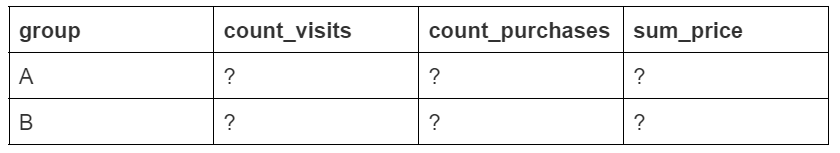
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [86]:
# Создаем таблицу для первичного анализа результатов A/B-тестирования.
analysis_df = updated_data.groupby(['group']).agg(
    {'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}
).reset_index().rename(
    columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

# Выводим информацию.
print(f"Количество посещений сайта в группе А: {analysis_df['count_visits'].iloc[0]}.")
print(f"Количество посещений сайта в группе B: {analysis_df['count_visits'].iloc[1]}.")

Количество посещений сайта в группе А: 145307.
Количество посещений сайта в группе B: 145381.


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### Вывод:
*Исходя их полученных данных мы видим, что посещение в группе В немного выше, чем в группе В. Но данная разница составляет лишь 74 человека, а это лишь 0.018%. Получить идеально сбалансированную выборку крайне сложно. И учитывая, что наш процент различия между выборками составляет лишь 0.018%, то это не окажет огромного влияния на наш аналих данных.*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [87]:
# Добавляем столбцы с конверсией покупки и средним чеком.
analysis_df['conversion'] = (analysis_df['count_purchases'] / analysis_df['count_visits'])*100
analysis_df['mean_check'] = (analysis_df['sum_price'] / analysis_df['count_purchases'])

# Выводим информацию.
print(f"Конверсия покупок в группе А: {round(analysis_df['conversion'].iloc[0], 2)}.")
print(f"Конверсия покупок в группе B: {round(analysis_df['conversion'].iloc[1], 2)}.")
print(f"Средний чек в группе А: {round(analysis_df['mean_check'].iloc[0])} руб.")
print(f"Средний чек в группе B: {round(analysis_df['mean_check'].iloc[1])} руб.")

Конверсия покупок в группе А: 12.03.
Конверсия покупок в группе B: 11.89.
Средний чек в группе А: 81076 руб.
Средний чек в группе B: 88665 руб.


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### Вывод:
*Исходя их полученных данных мы видим, что конверсия покупок в группе А выше чем в группе В, а средний чек в группе В выше. Это нам говорит о том, что в группе А клиенты покупают больше туров, но за меньшую цену. И соответственно наоборот в группе В цена приобретенных туров была выше, чем в группе А.*

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [88]:
# Строим сводную таблицу, которая показывает зависимость количества продаж от группы и цены тура.
pivot_df = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)
# Выводим таблицу.
display(pivot_df)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Количество проданных туров за 60000 рублей в группе А: 5271.
Количество проданных туров за 60000 рублей в группе B: 1730.


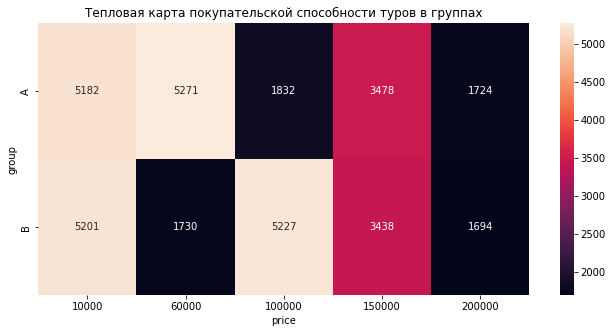

In [89]:
# Создаем тепловую карту сводной таблицы.
fig = plt.figure(figsize=(11, 5))
ax = sns.heatmap(pivot_df, fmt='.0f', annot=True);

# Задаем название тепловой карте.
ax.set_title('Тепловая карта покупательской способности туров в группах');

# Выводим информацию.
print(f"Количество проданных туров за 60000 рублей в группе А: {pivot_df[60000].loc['A']}.")
print(f"Количество проданных туров за 60000 рублей в группе B: {pivot_df[60000].loc['B']}.")

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### Вывод:
*В группе А наибольшая покупательсткая способность по турам за 60000 руб. А в группе В по турам за 100000 руб. В группе А предпочитают ехать в Турцию, а в группе В в Тайланд. А в целом, если посмотреть на тепловую карту, то видно, что за туры по 10000 руб., 150000 руб., 200000 руб. покупательская способность зависит лишь от цены, а не от группы.*

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [90]:
# Построим таблицу с ежедневными данными результатов проведения A/B-тестирования.
daily_data = updated_data.groupby(['date', 'group']).agg(
    {'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index().rename(
    columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

# Добавляем столбцы о ежедневной конверсии и ежедневном среднем чеке.
daily_data['conversion'] = (daily_data['count_purchases'] / daily_data['count_visits'])*100
daily_data['mean_check'] = daily_data['sum_price'] / daily_data['count_purchases']

# Находим конверсию в группах за 3 января 2021 года.
conversion_group_a = round(daily_data[(daily_data['group'] == 'A') & (
    daily_data['date'] == '2021-01-03')]['conversion'].iloc[0], 2)
conversion_group_b = round(daily_data[(daily_data['group'] == 'B') & (
    daily_data['date'] == '2021-01-03')]['conversion'].iloc[0], 2)

# Выводим результат.
print(f"Конверсия за 3 января 2021 года в группе А: {conversion_group_a}%.")
print(f"Конверсия за 3 января 2021 года в группе В: {conversion_group_b}%.")

# Находим сумму среднего чека в группах за 3 января 2021 года.
mean_check_group_a = round(daily_data[(daily_data['group'] == 'A') & (
    daily_data['date'] == '2021-01-03')]['mean_check'].iloc[0])
mean_check_group_b = round(daily_data[(daily_data['group'] == 'B') & (
    daily_data['date'] == '2021-01-03')]['mean_check'].iloc[0])

# Выводим результат.
print(f"Средний чек за 3 января 2021 года в группе А: {mean_check_group_a} руб.")
print(f"Средний чек за 3 января 2021 года в группе В: {mean_check_group_b} руб.")

Конверсия за 3 января 2021 года в группе А: 11.34%.
Конверсия за 3 января 2021 года в группе В: 11.39%.
Средний чек за 3 января 2021 года в группе А: 82888 руб.
Средний чек за 3 января 2021 года в группе В: 87480 руб.


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [91]:
# Находим кумулятивное количество посещений страницы, количество покупок и сумму покупок.
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()

# Находим кумулятивную конверсию и кумулятивный средний чек.
daily_data['cum_conversion'] = (daily_data['cum_count_purchases'] / daily_data['cum_count_visits'])*100
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_count_purchases']

# Находим кумулятивную конверсию в группе В за 20 января 2021 года.
cum_conversion_group_b = round(daily_data[(daily_data['group'] == 'B') & (
    daily_data['date'] == '2021-01-20')]['cum_conversion'].iloc[0], 2)

# Выводим результат.
print(f"Кумулятивная конверсия в группе В за 20 января 2021 год: {cum_conversion_group_b}%.")

# Находим кумулятивный средний чек в группе А за 12 января 2021 года.
cum_mean_check_group_a = round(daily_data[(daily_data['group'] == 'A') & (
    daily_data['date'] == '2021-01-12')]['cum_mean_check'].iloc[0])

# Выводим результат.
print(f"Кумулятивный средний чек в группе А за 12 января 2021 год: {cum_mean_check_group_a} руб.")

Кумулятивная конверсия в группе В за 20 января 2021 год: 11.9%.
Кумулятивный средний чек в группе А за 12 января 2021 год: 81492 руб.


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

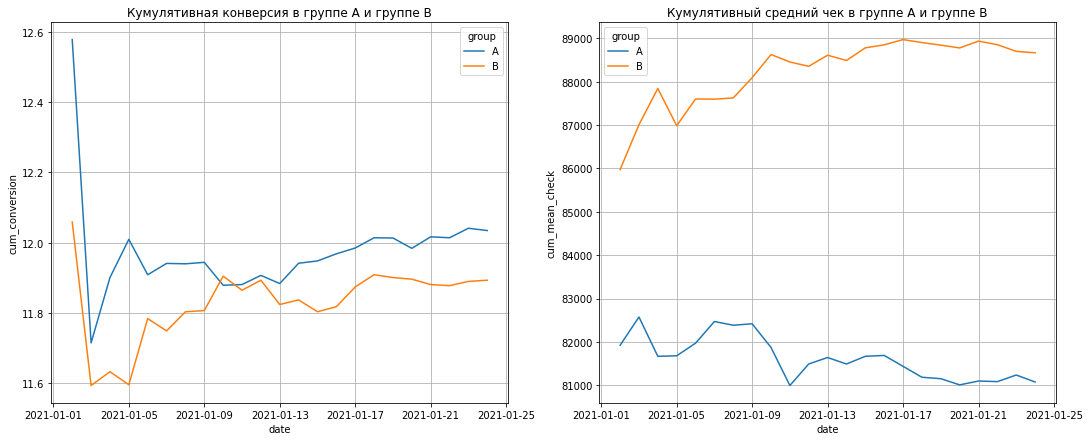

In [92]:
# Строим линейные графики кумулятивной конверсии и кумулятивного среднего чека.
fig, axes = plt.subplots(1, 2, figsize=(18,7))
sns.lineplot(data=daily_data, x='date', y='cum_conversion', hue='group', ax=axes[0])
sns.lineplot(data=daily_data, x='date', y='cum_mean_check', hue='group', ax=axes[1])

# Задаем названия графикам.
axes[0].set_title('Кумулятивная конверсия в группе А и группе В');
axes[1].set_title('Кумулятивный средний чек в группе А и группе В');

# Устанавливаем сетку.
axes[0].grid()
axes[1].grid()

### Вывод:
*В начале периода наблюдаются резкие скачки конверсии. До 13 января 2021г. конверсия в группах была нестабильна и после 18 января кривая начинает плавно стабилизироваться. При этом конверсия в группе А немного выше чем в группе В.* 
    
*Что касается среднего чека, то мы видим, что в группе В сумма чека значительно выше на всем промежутке времени и по сревнению с началом периода пошла на увеличение, а в группе А наоборот, сумма чека снижается. После 17 января не наблюдается резких скачков. В результате мы получили стабилизированные данные и можем переходить к проверке статистической значимости разницы между метриками в группах.*

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [93]:
# Группируем данные по признаку группы и находим количество совершенных покупок
# и количество наблюдений.
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

# Создаем гипотезу.
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'

# Задаем уровень значимости.
alpha = 0.05

# Вычисляем p-value и выводим его.
_, p = proportions_ztest(
    count=converted_piv['sum'],
    nobs=converted_piv['count'],
    alternative='larger'
)
print(f"p-value - {round(p, 3)}.")

# Сравнение p-value с уровнем значимости.
if p > alpha:
    print(f" Мы принимаем нулевую гипотезу: '{H0}', т.к. {round(p, 3)} > {alpha}.")
else:
    print(f" Мы отвергаем нулевую гипотезу и принимает альтернативную: '{Ha}', т.к. {round(p, 3)} <= {alpha}.")

p-value - 0.12.
 Мы принимаем нулевую гипотезу: 'Конверсии в группах А и B равны', т.к. 0.12 > 0.05.


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### Вывод:
*Z-тест для пропорций показал, что при уровне значимости 5% нет статистической разницы между конверсиями в группах. p-value оказалось выше уровня значимости. Даже если мы ослабим требования и увеличим уровень значимости до 0.1, то и в этом случае наша альтернативная гипотеза не подтвердится. Поэтому можно сделать вывод, что по метрике конверсии два варианта посадочной страницы официального сайта компании одинаково эффективны. Чтобы точно убедиться в наших рассуждениях найдем доверительный интервал для конверсий и разницы между ними.*

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [94]:
def proportions_conf_interval(n, xp, gamma=0.95):
    """Функция нахождения доверительного интервала пропорции.
    У функции три аргумента: n — размер выборки, xp — выборочная пропорция
    и gamma — уровень надёжности. 
    Функция возвращает кортеж из вычисленных границ доверительного интервала, 
    умноженных на 100 % и округлённых до второго знака после запятой.
    """
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (xp * (1 - xp) / n) ** 0.5
    lower_bound = xp - eps
    upper_bound = xp + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


def diff_proportions_conf_interval(n, xp, gamma=0.95):
    """Функция нахождения доверительного интервала разницы конверсий.
    У функции три аргумента: n — размер выборки, xp — выборочная пропорция
    и gamma — уровень надёжности. 
    Функция возвращает кортеж из вычисленных границ доверительного интервала разници конверсий, 
    умноженных на 100 % и округлённых до второго знака после запятой.
    """
    alpha = 1 - gamma
    diff = xp[1] - xp[0]
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


# Группируем данные по группам и находим размер выборки и выборочную пропорцию.
ab_df = updated_data.groupby(['group']).agg({'user_id': 'count', 'purchase': 'mean'})

# Запускаем функцию нахождения доверительного интервала пропорции по группе А.
conf_interval_a = proportions_conf_interval(
n=ab_df['user_id'].iloc[0],
xp=ab_df['purchase'].iloc[0]
)

# Запускаем функцию нахождения доверительного интервала пропорции по группе В.                                    
conf_interval_b = proportions_conf_interval(
n=ab_df['user_id'].iloc[1],
xp=ab_df['purchase'].iloc[1]
)
# Выводим результат.
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

# Запускаем функцию нахождения доверительного интервала разницы конверсий.
diff_interval = diff_proportions_conf_interval(
n=[ab_df['user_id'].iloc[0], ab_df['user_id'].iloc[1]],
xp=[ab_df['purchase'].iloc[0], ab_df['purchase'].iloc[1]]
)
# Выводим результат.
print('Доверительный интервал для разности конверсий: {}'.format(diff_interval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### Вывод:
*Получив доверительные интервалы в группе А и группе В и сопоставив результаты можно явно увидеть пересечение интервалов. Поэтому мы не можем явно сказать, есть ли разница в конверсиях, ведь истенное значение конверсий в группах может совпасть. Поэтому мы также рассчитали доверительный интервал для разности конверсий и получили (-0.38, 0.09). Наш интервал охватывает точку 0. И это позвояляет еще раз убедиться, что нет статистической разницы между конверсиями в группах А и В.*

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [95]:
# Создаем гипотезу.
H0 = 'Распределения в обеих группах нормальные.'
H1 = 'Распределение в одной или обеих группах отлично от нормального.'

# Задаем уровень значимости.
alpha = 0.05

# Вычисляем результат теста Шапиро-Уилка для выборок и выводим их.
shapiro_result_a = shapiro(daily_data[daily_data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(daily_data[daily_data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости.
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные.


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [96]:
# Создаем гипотезу.
H0 = 'Ежедневные средние чеки в группах А и B равны.'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B.'

# Задаем уровень значимости.
alpha = 0.05

# Вычисляем результат T-теста для выборок и выводим их.
results = ttest_ind(
    daily_data[daily_data['group'] == 'A']['mean_check'],
    daily_data[daily_data['group'] == 'B']['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости.
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны.
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B.


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### Вывод:
*Для сравнения вариантов дизайна страницы по метрике среднего чека мы выбрали t-test, т.к. мы его можем применить для определения того, как средние значения двух наборов данных отличаются друг от друга, если дисперсия не задана. В результате мы получили p-value 0.0, что меньше заданного уровня значимости. В результате мы приняли гипотезу о том, что средний чек в группе А меньше, чем в группе В. Мы это также явно наблюдали при визуальзации кумулятивного среднего чека. Поэтому с уверенностью можно сказать, что есть статистическая разница между ежедневными чеками в группах.*

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [97]:
def unknown_std_conf_interval(n, x_mean, x_std, gamma=0.95):
    """Функция нахождения доверительного интервала для среднего
    при неизвестном истинном стандартном отклонении.
    У функции 4 аргумента: n — размер выборки, x_mean — выборочное среднее,
    x_std - выборочное стандартное отклонение и gamma — уровень надёжности. 
    Функция возвращает кортеж из вычисленных границ доверительного интервала.
    """
    k = n - 1
    alpha = 1 - gamma
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std/(n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    return round(lower_bound), round(upper_bound)

# Разделяет данные по группам.
group_a_df = daily_data[daily_data['group'] == 'A']
group_b_df = daily_data[daily_data['group'] == 'B']

# Находим доверительный интервал среднего чека по группе А.
confidence_interval_a = unknown_std_conf_interval(
    n = group_a_df['count_visits'].count(),
    x_mean = group_a_df['mean_check'].mean(),
    x_std = group_a_df['mean_check'].std()
)

# Находим доверительный интервал среднего чека по группе В.
confidence_interval_b = unknown_std_conf_interval(
    n = group_b_df['count_visits'].count(),
    x_mean = group_b_df['mean_check'].mean(),
    x_std = group_b_df['mean_check'].std()
)

# Выводим результаты.
print('Доверительный интервал среднего чека в группе А: {}'.format(confidence_interval_a))
print('Доверительный интервал среднего чека в группе В: {}'.format(confidence_interval_b))

Доверительный интервал среднего чека в группе А: (79630, 82308)
Доверительный интервал среднего чека в группе В: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### Вывод:
*Мы нашли доверительные интервалы в группах и между ними нет пересечений. Доверительный интервал среднего чека в группе Б выше чем в группе А. Можно сделать вывод, что метрика средний чек является стаcтически значимой.*

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

*Проведя анализ А/В тестирования мы выяснили, что вариант дизайна в обоих группах на метрику конверсии оказывает одинаковый результат, p-value оказалось выше установленного уровня значимости и происходит пересечение доверительных интервалов конверсии, поэтому между конверсиями нет статиcческой разницы. А вот по метрике среднего чека видна разница. Средний чек в группе В куда выше чем в группе А. При новом дизайне истенный средний чек может увеличиться от 5000 до 10000 руб. Поэтому, если данное увеличение устраивает компанию, то дизайн посадочной страницы в группе В является более эффектным, если компания хочет увеличить прибыль.*